In [26]:
from pathlib import Path
import seaborn as sns

import pandas as pd
import numpy as np

#from helpers import *
from sklearn.ensemble import (RandomForestRegressor, RandomForestClassifier)
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer 
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline

from IPython.display import display
import re
import matplotlib.pyplot as plt

In [2]:
ROOT = Path(r".")
# DATA = ROOT/'data' # if needed to make DATA.mkdir()
RAW = ROOT/'raw_data' # path to raw data account files
# NOTEBOOKS = ROOT/'notebooks'

print('ROOT:', ROOT)
# print('DATA:', DATA)
print('RAW', RAW)
# print('NOTEBOOKS:', NOTEBOOKS)
list(RAW.iterdir())

ROOT: .
RAW raw_data


[PosixPath('raw_data/.ipynb_checkpoints'),
 PosixPath('raw_data/data description.csv'),
 PosixPath('raw_data/example_code.py'),
 PosixPath('raw_data/testing.csv'),
 PosixPath('raw_data/training.csv')]

Reading the description data
---

In [3]:
# df_description = pd.read_csv(RAW/'data description.csv')
# df_description.head()

### function to display all the data
---

In [4]:
def display_all(df):
    with pd.option_context("display.max_rows", 1000, "display.max_columns", 1000, "display.max_colwidth", 1000):
        display(df)

### reading the training data, then getting a sample an the info to see what type of data we are dealing with
---

In [25]:
test_data = pd.read_csv(RAW/'testing.csv', index_col=0)
test_data.shape

(45, 495)

In [24]:
df = pd.read_csv(RAW/'training.csv', index_col=0)
display(df.shape)
display(df.head())
#display_all(df.info(3))

## target is the target variable column
## where is the most correlation to economic health? 

(416, 496)

,Area_2015,Area_2013,Population_Density_2018,Population _2018,Population_Density_2017,Population _2017,Population_Density_2016,Population _2016,Population_Density_2015,Population _2015,...,Transit_Proximate_Units_2013,Transit_Proximity_2011,Transit_Proximate_Units_2011,Transit_Ridership_2015,Transit_Ridership_Total_2015,Transit_Ridership_2014,Transit_Ridership_Total_2014,Transit_Ridership_2013,Transit_Ridership_Total_2013,target
0,411,411,5,2243,5,2241,5,2240,5,2216,...,1081,100.0,1082,35.0,879.0,43.0,1068.0,54.0,1348.0,0.160000
1,1156,1156,8,9758,8,8816,7,7986,7,7938,...,4746,100.0,4468,34.0,2346.0,35.0,2438.0,33.0,2697.0,0.708571
2,329,329,3,1120,3,1089,3,1080,3,1078,...,402,100.0,401,8.0,59.0,9.0,60.0,5.0,53.0,-0.014286
3,167,167,5,772,5,790,5,790,4,745,...,329,100.0,332,17.0,66.0,15.0,60.0,17.0,67.0,-0.008571
4,403,403,5,1839,5,1871,5,1853,4,1724,...,820,100.0,825,74.0,1258.0,77.0,1312.0,86.0,1375.0,0.091429


---
<br/>

### Checking for any duplicates


In [18]:
dups = df[df.duplicated()]
print('total duplicate rows:', dups.shape)
## no duplicates in this set

total duplicate rows: (0, 496)


---
<br/>

### Finding null or missing values


In [22]:
print(df.isnull().sum().sort_values(ascending=False).head(30))

##=> there are too many rows with missing values, so for this case
## ... we will use imputer (in the pipeline), instead of dropping 
## ...the rows with missing values

Proficiency_High_School_2017          134
Transit_Ridership_Total_2014          107
Transit_Ridership_2014                107
Transit_Ridership_Total_2013          106
Transit_Ridership_2013                106
Transit_Ridership_Total_2015          105
Transit_Ridership_2015                105
Adopt_a_Stream_Length_2011            101
Adopt_a_Stream_Length_2016            101
Adopt_a_Stream_Length_2013            101
Adopt_a_Stream_2011                   101
Adopt_a_Stream_2016                   101
Adopt_a_Stream_2013                   101
Adopt_a_Stream_2015                   100
Adopt_a_Stream_Length_2015            100
Adopt_a_Stream_2017                    98
Adopt_a_Stream_Length_2017             98
Solid_Waste_2013                       94
Recycling_Participating_Units_2013     94
Recycling_Participation_2013           94
Solid_Waste_Diverted_2013              94
Solid_Waste_Diversion_Rate_2013        94
Solid_Waste_Total_2013                 94
Highschool_Graduation_Rate_2017   

### making a list of all the unique column names, after stripping the numbers off
---
there are too many columns and this way it's easier to see all the columns labels

In [13]:
grouped_cols = set(df.columns.str.replace(r'\d+$','').str.replace(r'_',' ').str.strip().tolist())
grouped_cols

{'311 Calls',
 '311 Requests',
 'Adopt a Stream',
 'Adopt a Stream Length',
 'Adopt a Street',
 'Adopt a Street Length',
 'Age of Death',
 'Age of Residents',
 'Age of Residents moe',
 'Animal Control Call Rate',
 'Animal Control Calls',
 'Area',
 'Arts Participating Households',
 'Arts Participation',
 'Bachelors Degree',
 'Bachelors Degree moe',
 'Bicycle Friendliness',
 'Births to Adolescents',
 'Board Committee Participants',
 'Board Committee Participation',
 'Commercial Building Age',
 'Commercial Construction',
 'Commercial Construction Permitted Units',
 'Commercial Size',
 'Commercial Size Total',
 'Commuters Driving Alone',
 'Commuters Driving Alone moe',
 'Disorder Call Rate',
 'Disorder Calls',
 'Early Care Proximate Units',
 'Early Care Proximity',
 'Electricity Consumption',
 'Electricity Consumption Total',
 'Employment Rate',
 'Employment Rate moe',
 'Financial Services Proximate Units',
 'Fincancial Services Proximity',
 'Fire Call Rate',
 'Fire Calls',
 'Foreclosed Un

---
<br/>

### Finding Outliers

In [39]:
q1 = df.quantile(0.25)
q3 = df.quantile(0.75)
iqr = q3 - q1
print(iqr)

Area_2015                        550.500000
Area_2013                        549.750000
Population_Density_2018            4.000000
Population _2018                1432.250000
Population_Density_2017            3.000000
                                   ...     
Transit_Ridership_2014            65.000000
Transit_Ridership_Total_2014     747.000000
Transit_Ridership_2013            68.750000
Transit_Ridership_Total_2013     782.750000
target                             0.108571
Length: 496, dtype: float64


In [60]:
outliers_iqr = (df < (q1 - 1.5 * iqr)) | (df > (q3 + 1.5 * iqr))
outliers_iqr.head(15)

,Area_2015,Area_2013,Population_Density_2018,Population _2018,Population_Density_2017,Population _2017,Population_Density_2016,Population _2016,Population_Density_2015,Population _2015,...,Transit_Proximate_Units_2013,Transit_Proximity_2011,Transit_Proximate_Units_2011,Transit_Ridership_2015,Transit_Ridership_Total_2015,Transit_Ridership_2014,Transit_Ridership_Total_2014,Transit_Ridership_2013,Transit_Ridership_Total_2013,target
0,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,False,False,False,True,False,True,False,True,False,True,...,True,False,True,False,True,False,True,False,True,True
2,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
5,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
6,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
7,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
8,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
9,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


---
<br/>

### visualizing the data and applying corr to find any correlations

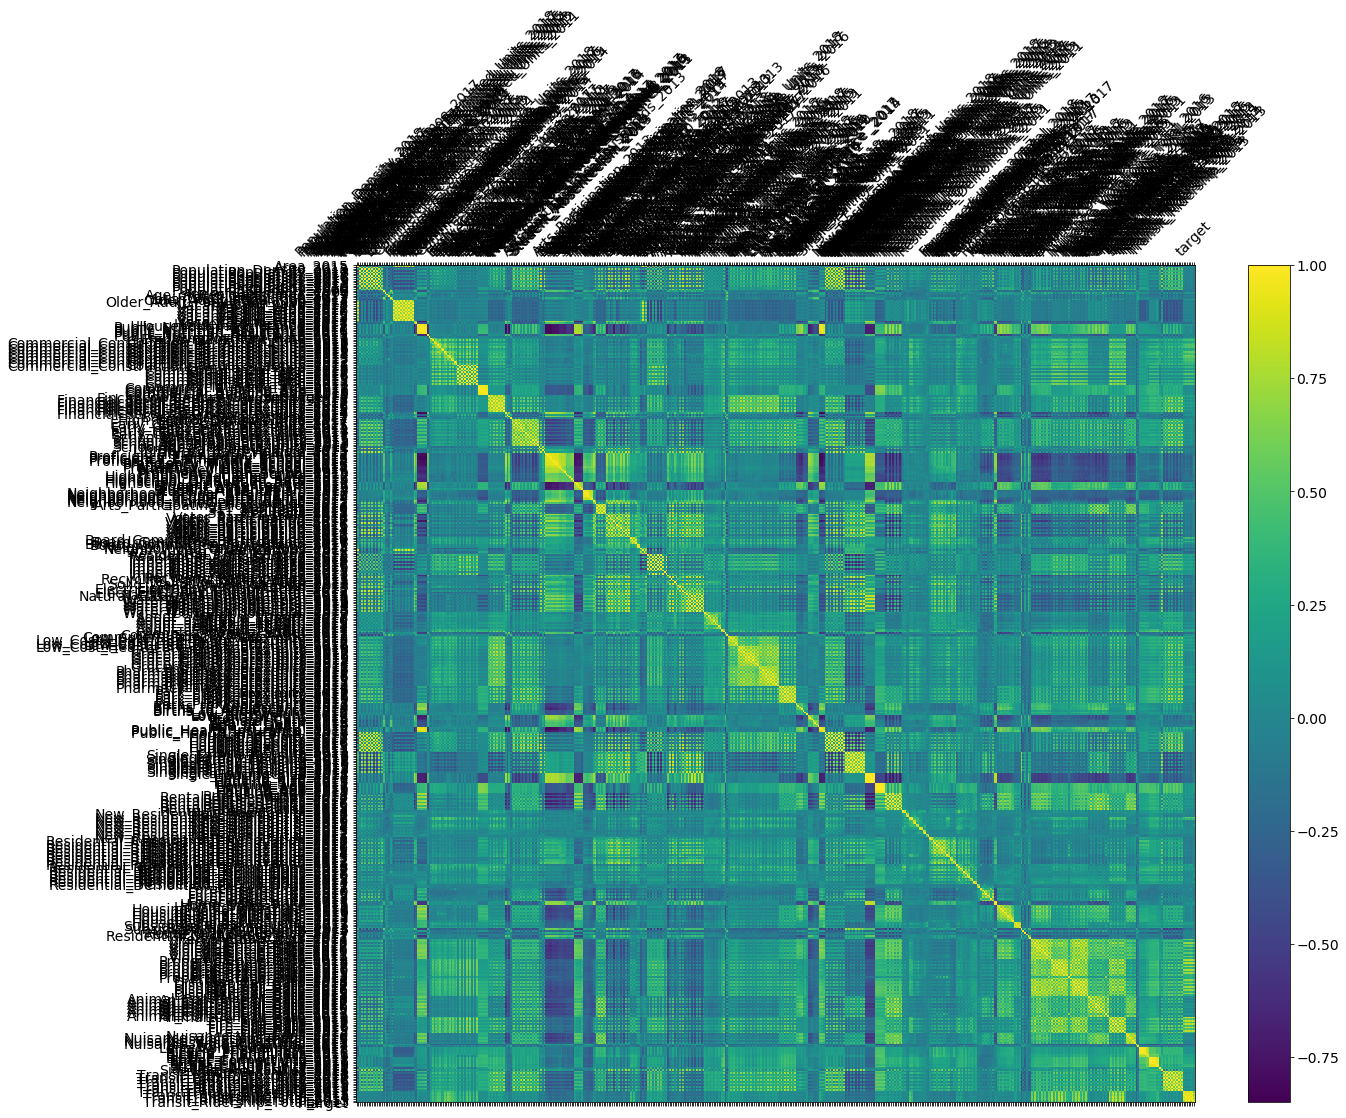

In [6]:
training_corr = df.corr()

## heatmap plot
f = plt.figure(figsize=(19, 15))
plt.matshow(training_corr, fignum=f.number)
plt.xticks(range(df.shape[1]), df.columns, fontsize=14, rotation=45)
plt.yticks(range(df.shape[1]), df.columns, fontsize=14)
cb = plt.colorbar()
cb.ax.tick_params(labelsize=14)
plt.title('Correlation Matrix', fontsize=16);

### displaying correlation for foreclosure

In [10]:
foreclo = df[[c for c in df.columns.tolist() if 'Foreclo' in c]+['target']].copy()
foreclo_corr = foreclo.corr()
foreclo_corr.style.background_gradient(cmap='coolwarm').set_precision(2)

,Foreclosures_2017,Foreclosed_Units_2017,Foreclosures_2016,Foreclosed_Units_2016,Foreclosures_2015,Foreclosed_Units_2015,Foreclosures_2013,Foreclosed_Units_2013,Foreclosures_2011,Foreclosed_Units_2011,target
Foreclosures_2017,1,0.6,0.065,0.096,0.31,0.051,0.054,0.052,0.026,0.053,-0.005
Foreclosed_Units_2017,0.6,1,0.11,0.28,0.15,0.22,0.17,0.26,0.12,0.26,-0.028
Foreclosures_2016,0.065,0.11,1,0.47,0.3,0.25,0.32,0.22,0.59,0.2,-0.049
Foreclosed_Units_2016,0.096,0.28,0.47,1,0.53,0.79,0.53,0.77,0.34,0.71,-0.065
Foreclosures_2015,0.31,0.15,0.3,0.53,1,0.72,0.57,0.47,0.38,0.44,-0.091
Foreclosed_Units_2015,0.051,0.22,0.25,0.79,0.72,1,0.51,0.82,0.34,0.78,-0.076
Foreclosures_2013,0.054,0.17,0.32,0.53,0.57,0.51,1,0.68,0.42,0.49,-0.095
Foreclosed_Units_2013,0.052,0.26,0.22,0.77,0.47,0.82,0.68,1,0.33,0.84,-0.064
Foreclosures_2011,0.026,0.12,0.59,0.34,0.38,0.34,0.42,0.33,1,0.51,-0.039
Foreclosed_Units_2011,0.053,0.26,0.2,0.71,0.44,0.78,0.49,0.84,0.51,1,-0.066


#### Age Correlation

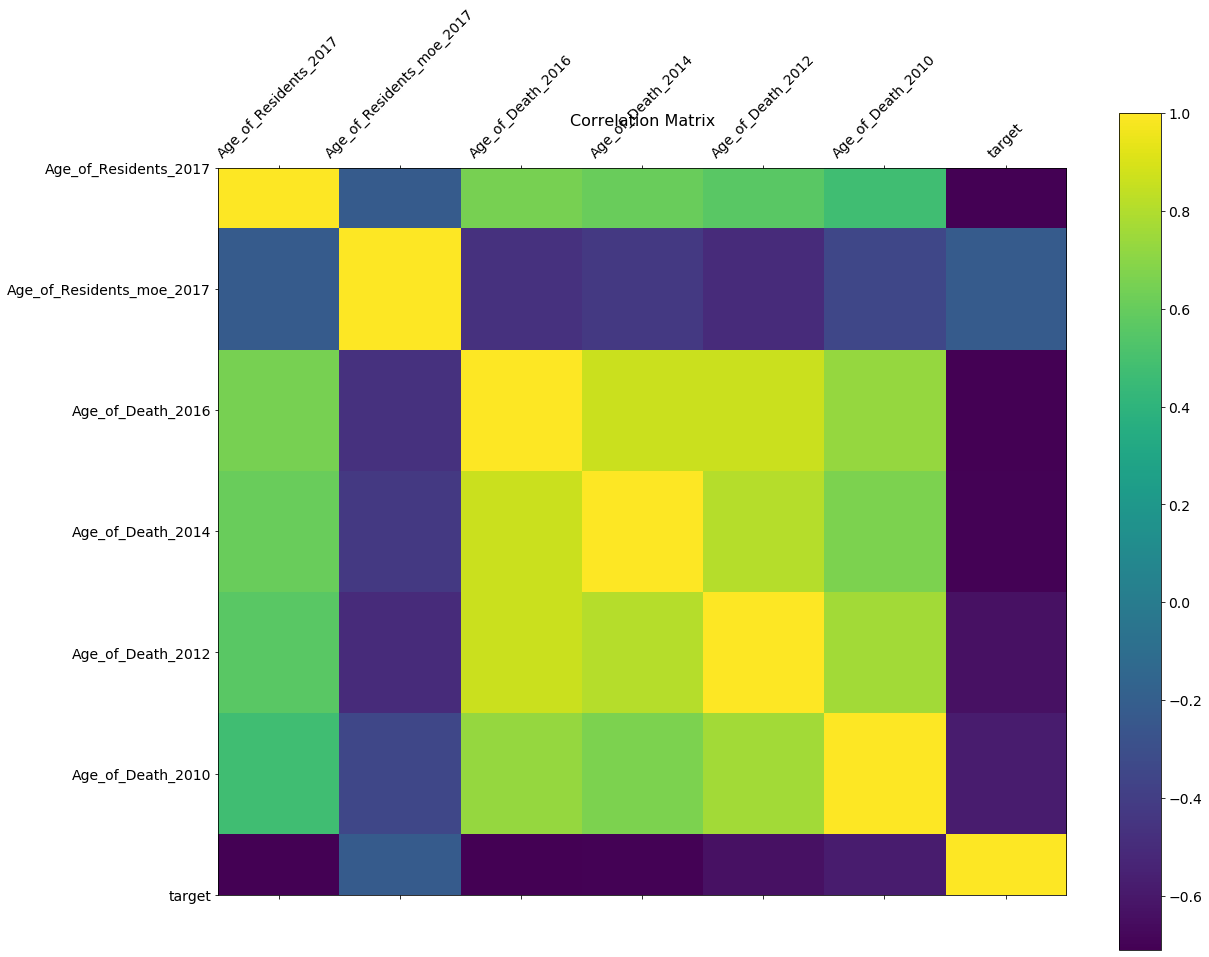

In [61]:
age = df[[c for c in df.columns.tolist() if 'Age_of' in c]+['target']].copy()
age_corr = age.corr()
age_corr.style.background_gradient(cmap='coolwarm').set_precision(2)

# heatmap plot for one group
f = plt.figure(figsize=(19, 15))
plt.matshow(age_corr.corr(), fignum=f.number)
plt.xticks(range(age_corr.shape[1]), age_corr.columns, fontsize=14, rotation=45)
plt.yticks(range(age_corr.shape[1]), age_corr.columns, fontsize=14)
cb = plt.colorbar()
cb.ax.tick_params(labelsize=14)
plt.title('Correlation Matrix', fontsize=16);

#### Transit correlation

In [14]:
transit = df[[c for c in df.columns.tolist() if 'Transit' in c]+['target']].copy()

transit_corr = transit.corr()
transit_corr.style.background_gradient(cmap='coolwarm').set_precision(2)

,Transit_Proximity_2018,Transit_Proximate_Units_2018,Transit_Proximity_2017,Transit_Proximate_Units_2017,Transit_Proximity_2016,Transit_Proximate_Units_2016,Transit_Proximity_2015,Transit_Proximate_Units_2015,Transit_Proximity_2013,Transit_Proximate_Units_2013,Transit_Proximity_2011,Transit_Proximate_Units_2011,Transit_Ridership_2015,Transit_Ridership_Total_2015,Transit_Ridership_2014,Transit_Ridership_Total_2014,Transit_Ridership_2013,Transit_Ridership_Total_2013,target
Transit_Proximity_2018,1,0.59,0.97,0.58,0.97,0.59,0.97,0.59,0.94,0.57,0.92,0.57,0.17,0.093,0.17,0.093,0.17,0.095,0.08
Transit_Proximate_Units_2018,0.59,1,0.57,0.98,0.58,0.97,0.57,0.97,0.55,0.95,0.54,0.94,0.057,0.036,0.054,0.037,0.065,0.044,0.056
Transit_Proximity_2017,0.97,0.57,1,0.6,1,0.61,0.99,0.61,0.96,0.59,0.94,0.59,0.16,0.091,0.16,0.092,0.17,0.094,0.08
Transit_Proximate_Units_2017,0.58,0.98,0.6,1,0.6,0.99,0.59,0.99,0.58,0.97,0.56,0.96,0.057,0.038,0.055,0.04,0.066,0.046,0.039
Transit_Proximity_2016,0.97,0.58,1,0.6,1,0.61,0.99,0.61,0.96,0.59,0.94,0.59,0.16,0.092,0.16,0.093,0.17,0.094,0.079
Transit_Proximate_Units_2016,0.59,0.97,0.61,0.99,0.61,1,0.6,0.99,0.58,0.98,0.57,0.97,0.052,0.036,0.051,0.037,0.059,0.043,0.03
Transit_Proximity_2015,0.97,0.57,0.99,0.59,0.99,0.6,1,0.61,0.97,0.59,0.95,0.59,0.16,0.093,0.16,0.094,0.17,0.096,0.075
Transit_Proximate_Units_2015,0.59,0.97,0.61,0.99,0.61,0.99,0.61,1,0.59,0.99,0.58,0.97,0.051,0.034,0.05,0.036,0.059,0.041,0.031
Transit_Proximity_2013,0.94,0.55,0.96,0.58,0.96,0.58,0.97,0.59,1,0.61,0.98,0.6,0.16,0.091,0.16,0.093,0.16,0.094,0.076
Transit_Proximate_Units_2013,0.57,0.95,0.59,0.97,0.59,0.98,0.59,0.99,0.61,1,0.59,0.99,0.044,0.028,0.04,0.028,0.045,0.032,0.02


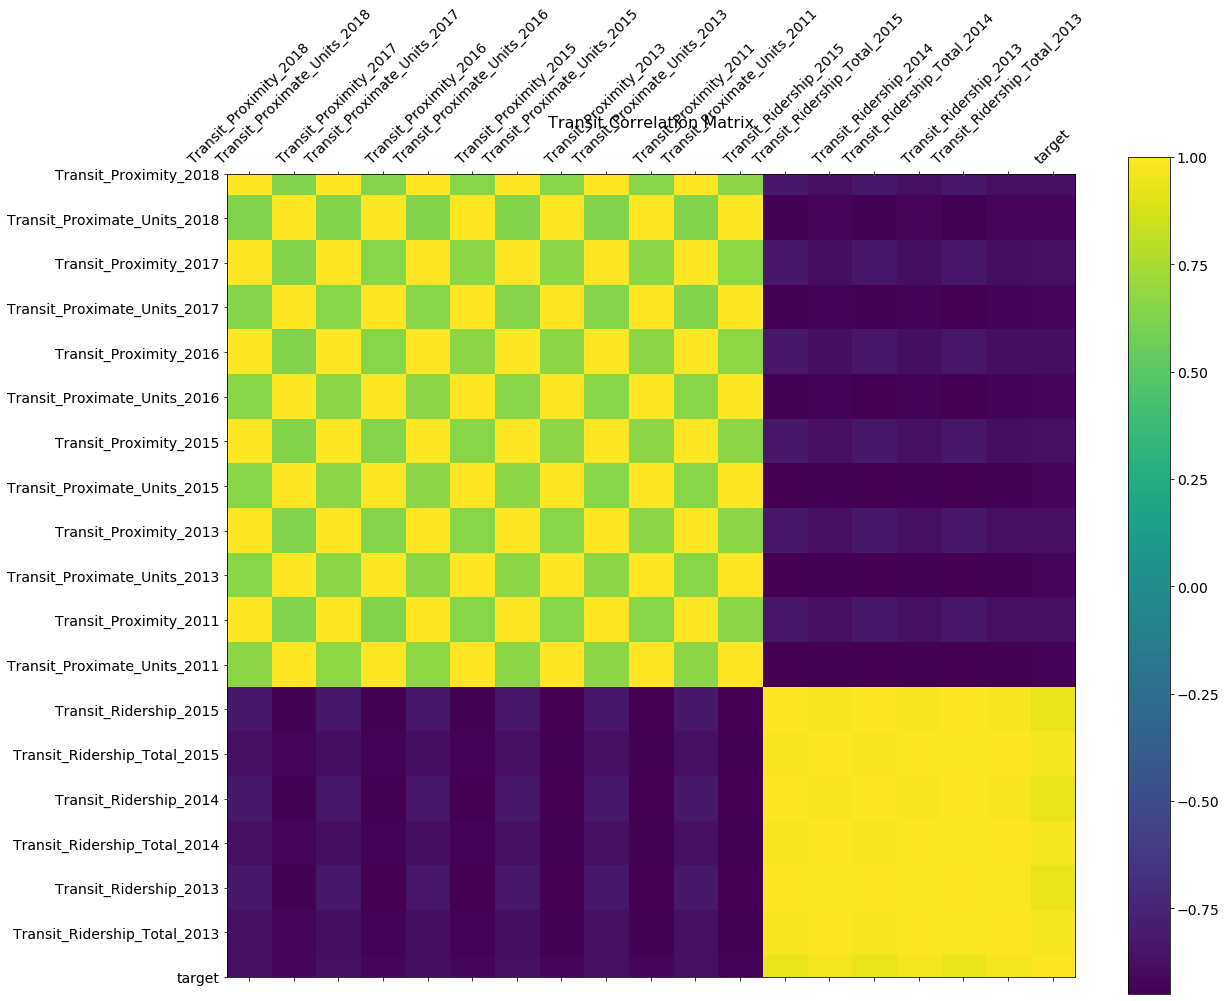

In [62]:
## heatmap for transit correlation
f = plt.figure(figsize=(19, 15))
plt.matshow(transit_corr.corr(), fignum=f.number)
plt.xticks(range(transit_corr.shape[1]), transit_corr.columns, fontsize=14, rotation=45)
plt.yticks(range(transit_corr.shape[1]), transit_corr.columns, fontsize=14)
cb = plt.colorbar()
cb.ax.tick_params(labelsize=14)
plt.title('Transit Correlation Matrix', fontsize=16);

### displaying the correlation as a list, sorted descend 
---

In [9]:
df = training_corr['target'].sort_values(ascending=False)
df.head(20)

target                          1.000000
Transit_Ridership_Total_2013    0.814471
Transit_Ridership_Total_2014    0.811039
Transit_Ridership_Total_2015    0.810096
Fire_Call_Rate_2017             0.778919
Fire_Call_Rate_2015             0.774298
Fire_Call_Rate_2018             0.766080
Fire_Call_Rate_2013             0.765457
Fire_Call_Rate_2016             0.753414
Property_Crime_Rate_2017        0.702375
Transit_Ridership_2014          0.692491
Transit_Ridership_2013          0.683304
Property_Crime_Rate_2015        0.678440
Property_Crime_Rate_2016        0.661774
Transit_Ridership_2015          0.661694
Property_Crime_Rate_2018        0.651956
Disorder_Call_Rate_2016         0.637427
Disorder_Call_Rate_2017         0.622990
Property_Crime_Rate_2013        0.599501
Disorder_Call_Rate_2018         0.579866
Name: target, dtype: float64